In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
import itertools

In [152]:
df=pd.read_csv('product a.csv', parse_dates=['Month-Year'], index_col='Month-Year')

In [153]:
sales_a= df.drop(['Product Name','Product Category'],axis=1)

In [154]:
sales_a.shape

(60, 1)

In [155]:
sales_a.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2019-01-01 to 2023-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   60 non-null     int64
dtypes: int64(1)
memory usage: 960.0 bytes


In [156]:
sales_a['Sales'].sum()

3213992

Text(0.5, 1.0, 'Product A')

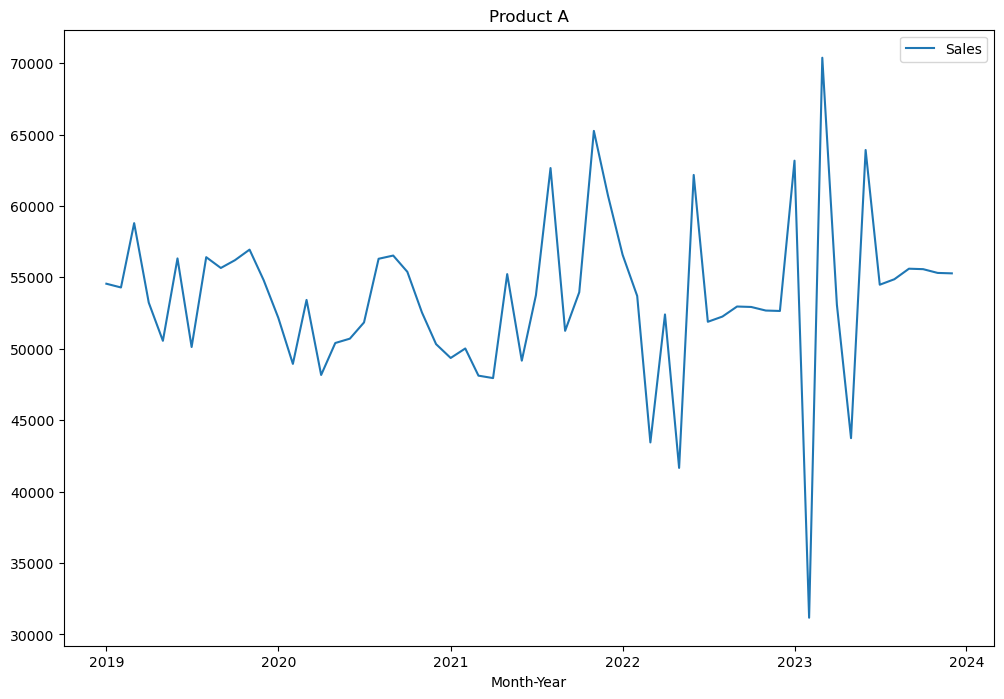

In [157]:
plt.figure(figsize=(12,8))
sns.lineplot(sales_a)
plt.title('Product A')

In [158]:
from statsmodels.tsa.stattools import adfuller

In [159]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [160]:
adf_test(sales_a)

ADF Statistics: -10.095004165158468
p- value: 1.0967344875767964e-17
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


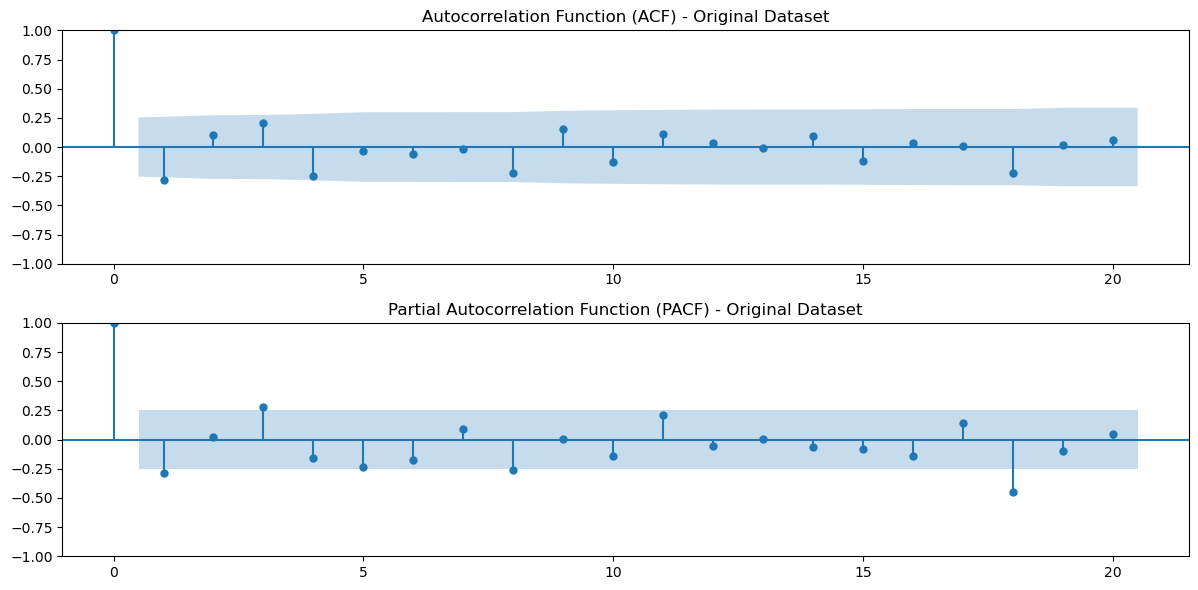

In [161]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_a, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Original Dataset')

plt.subplot(212)
plot_pacf(sales_a, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Original Dataset')

plt.tight_layout()
plt.show()

In [162]:
train= sales_a[:48]
test=sales_a[48:]

In [163]:
print(len(train),len(test))

48 12


In [164]:
order=[]
for p in range(6):
    # Loop over MA order
    for q in range(2):
        # Fit model        
#       model= ARIMA(sales_b, order=(p,1,q))
        model_t = ARIMA(train['Sales'], order=(p,0,q))
        model_test=model_t.fit() 
        pred=model_test.predict(start=len(train), end=(len(sales_a)-1))
        mae = mean_absolute_error(test, pred)
        mape = np.mean(np.abs((test - pred) / test)) * 100
        mse=mean_squared_error(test, pred)
        rmse = np.sqrt(mean_squared_error(test, pred))
        # Add order and scores to list        
        order.append((p, q, model_test.aic, model_test.bic,mae, mse, rmse))
#Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order, columns=['p','q', 'aic', 'bic', 'mae','mse', 'rmse'])

In [165]:
# Sort by AIC
print(order_df.sort_values('aic'))

    p  q         aic         bic          mae           mse         rmse
0   0  0  944.917115  948.659517  6744.593750  9.218464e+07  9601.283000
9   4  1  946.140092  959.238499  6807.876215  9.236583e+07  9610.714516
7   3  1  946.161516  957.388723  6731.261947  9.162007e+07  9571.837496
2   1  0  946.272123  951.885726  6750.019225  9.227674e+07  9606.078067
1   0  1  946.497380  952.110983  6748.716458  9.226640e+07  9605.540084
4   2  0  946.805996  954.290800  6749.099007  9.210914e+07  9597.350510
11  5  1  947.591344  962.560952  6817.579387  9.233308e+07  9609.010244
8   4  0  947.682843  958.910049  6759.270148  9.185227e+07  9583.959075
3   1  1  947.879387  955.364191  6751.009872  9.224845e+07  9604.605618
10  5  0  948.653187  961.751594  6765.777212  9.168529e+07  9575.243495
6   3  0  948.755461  958.111467  6749.109727  9.210686e+07  9597.231793
5   2  1  948.822214  958.178219  6749.083609  9.210852e+07  9597.318605


In [166]:
m_arima= ARIMA(train, order=(0,0,0))
model_arima=m_arima.fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                          ARIMA   Log Likelihood                -470.459
Date:                Tue, 14 May 2024   AIC                            944.917
Time:                        17:56:02   BIC                            948.660
Sample:                    01-01-2019   HQIC                           946.331
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.328e+04    640.196     83.223      0.000     5.2e+04    5.45e+04
sigma2      1.926e+07   3.24e+06      5.944      0.000    1.29e+07    2.56e+07
Ljung-Box (L1) (Q):                   0.70   Jarque-

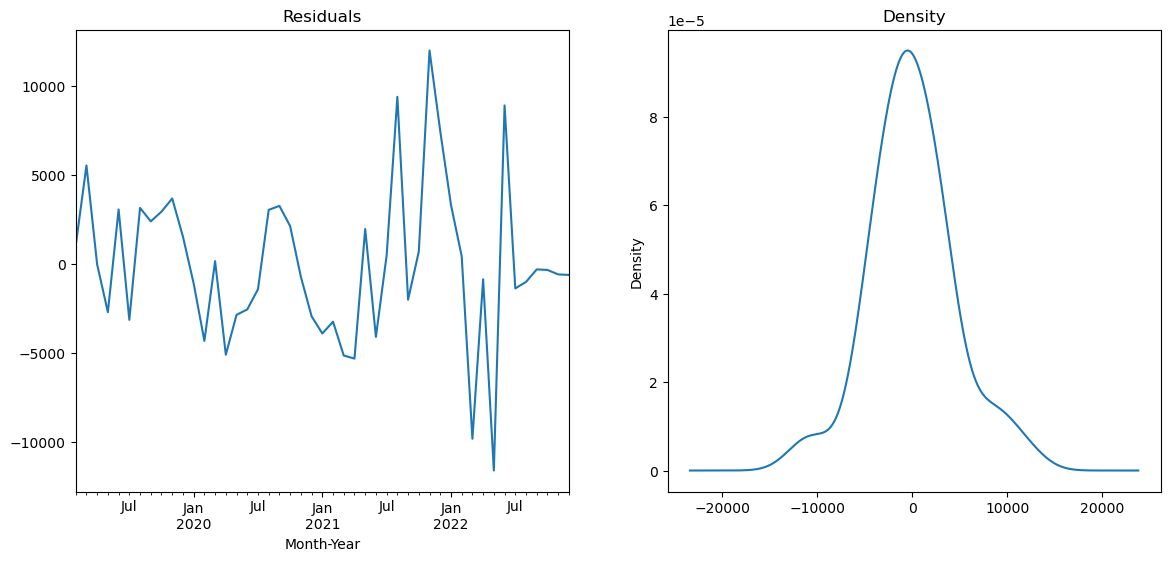

In [167]:
residuals= model_arima.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(14, 6))
residuals.plot(title='Residuals',ax=ax[0])
residuals.plot(title='Density',kind='kde',ax=ax[1])
plt.show()

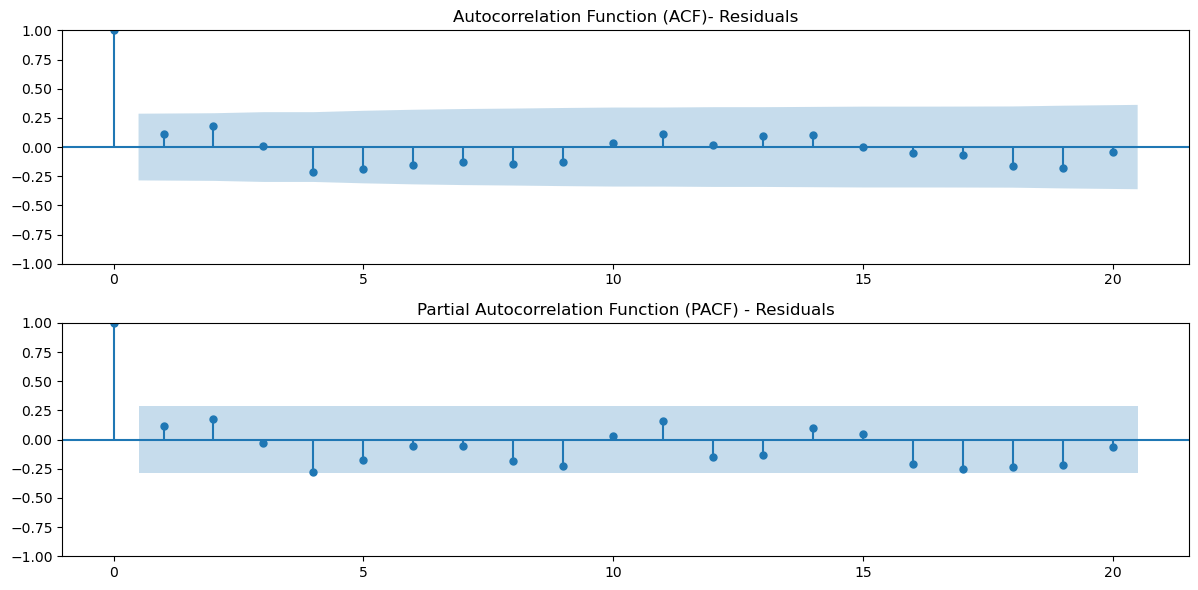

In [168]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)- Residuals')

plt.subplot(212)
plot_pacf(residuals, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Residuals')

plt.tight_layout()
plt.show()

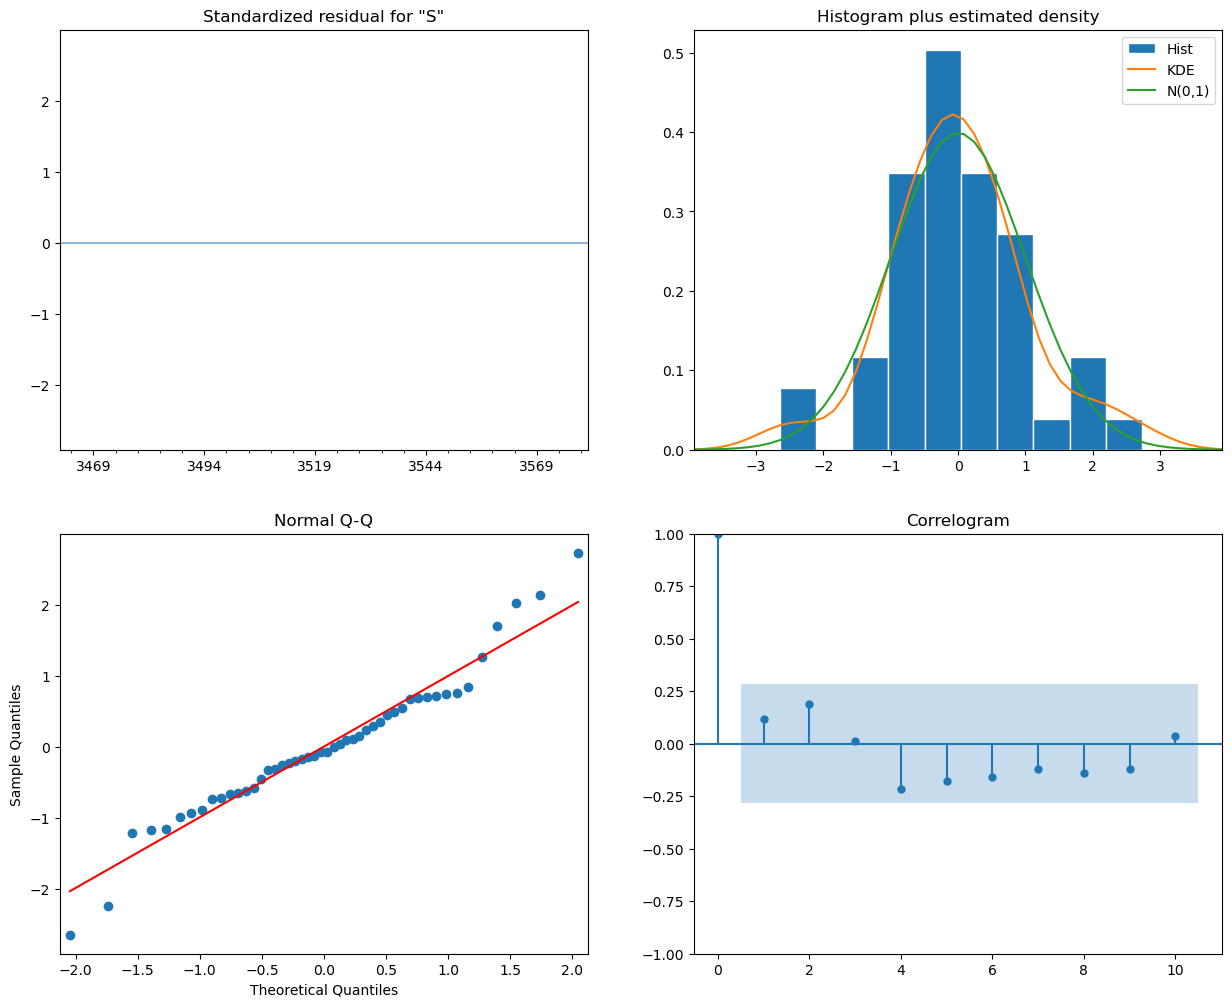

In [169]:
# Create the 4 diagostics plots
model_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [170]:
#pred_in_sample = model_arima.get_prediction(start=len(train), end=(len(sales_b)-1))
#sales_b['Forecast_ARIMA_p']=[None]*len(train) + list(pred)

In [171]:
#plt.figure(figsize=(12, 8))
#sns.lineplot(sales_b[['Sales','Forecast_ARIMA_p']])
#plt.title('Product B')
#plt.show()

In [172]:
pred=model_arima.predict(start=len(train), end=(len(sales_a)-1), dynamic = True)
sales_a['Forecast_ARIMA']=[None]*len(train) + list(pred)
#sales_b.plot()

In [173]:
#pred=model_arima.forecast(steps= len(test))
#sales_b['Forecast_ARIMA']=[None]*len(train) + list(pred)
#sales_b.plot()

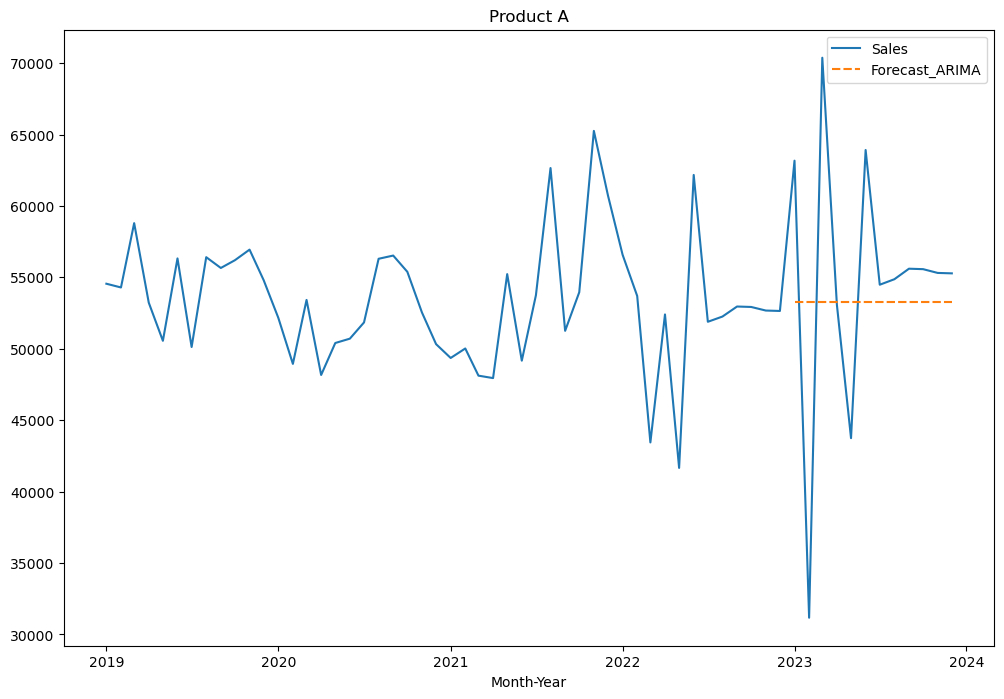

In [174]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_a[['Sales','Forecast_ARIMA']])
plt.title('Product A')
plt.show()

In [175]:
mae_arima= mean_absolute_error(test,pred)
mse_arima=mean_squared_error(test, pred)
mape_arima= mean_absolute_percentage_error(test,pred)
rmse_arima= np.sqrt(mean_squared_error(test,pred))

print(f'MAE - ARIMA: {mae_arima}')
print(f'MAPE - ARIMA: {mape_arima}')
print(f'MSE - ARIMA: {mse_arima}')
print(f'RMSE - ARIMA: {rmse_arima}')

MAE - ARIMA: 6744.593749999988
MAPE - ARIMA: 0.1420423384192015
MSE - ARIMA: 92184635.2539062
RMSE - ARIMA: 9601.283000407091


# FORECASTING

In [176]:
f_arima= ARIMA(sales_a['Sales'], order=(0,0,0))
model_f_arima=f_arima.fit()

In [180]:
forecast_=model_f_arima.predict(start=len(sales_a), end=(len(sales_a)+11), dynamic = True)

In [181]:
forecast_

2024-01-01    53566.533333
2024-02-01    53566.533333
2024-03-01    53566.533333
2024-04-01    53566.533333
2024-05-01    53566.533333
2024-06-01    53566.533333
2024-07-01    53566.533333
2024-08-01    53566.533333
2024-09-01    53566.533333
2024-10-01    53566.533333
2024-11-01    53566.533333
2024-12-01    53566.533333
Freq: MS, Name: predicted_mean, dtype: float64

Text(0.5, 1.0, 'Product A')

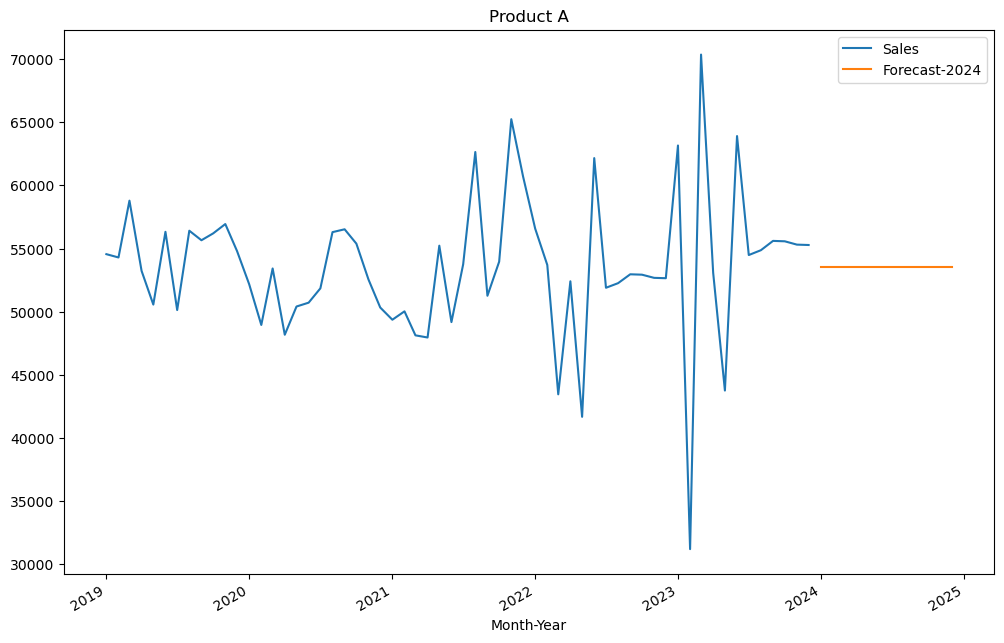

In [182]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_a[['Sales']])
forecast_.plot(legend=True, label='Forecast-2024')
plt.title('Product A')

In [186]:
arima_forecast_model=model_f_arima.get_forecast(steps=12)

mean_forecast= arima_forecast_model.predicted_mean
dates = mean_forecast.index

confidence_intervals= arima_forecast_model.conf_int()

In [187]:
print(mean_forecast,confidence_intervals)

2024-01-01    53566.533333
2024-02-01    53566.533333
2024-03-01    53566.533333
2024-04-01    53566.533333
2024-05-01    53566.533333
2024-06-01    53566.533333
2024-07-01    53566.533333
2024-08-01    53566.533333
2024-09-01    53566.533333
2024-10-01    53566.533333
2024-11-01    53566.533333
2024-12-01    53566.533333
Freq: MS, Name: predicted_mean, dtype: float64              lower Sales   upper Sales
2024-01-01  41985.053596  65148.013071
2024-02-01  41985.053596  65148.013071
2024-03-01  41985.053596  65148.013071
2024-04-01  41985.053596  65148.013071
2024-05-01  41985.053596  65148.013071
2024-06-01  41985.053596  65148.013071
2024-07-01  41985.053596  65148.013071
2024-08-01  41985.053596  65148.013071
2024-09-01  41985.053596  65148.013071
2024-10-01  41985.053596  65148.013071
2024-11-01  41985.053596  65148.013071
2024-12-01  41985.053596  65148.013071


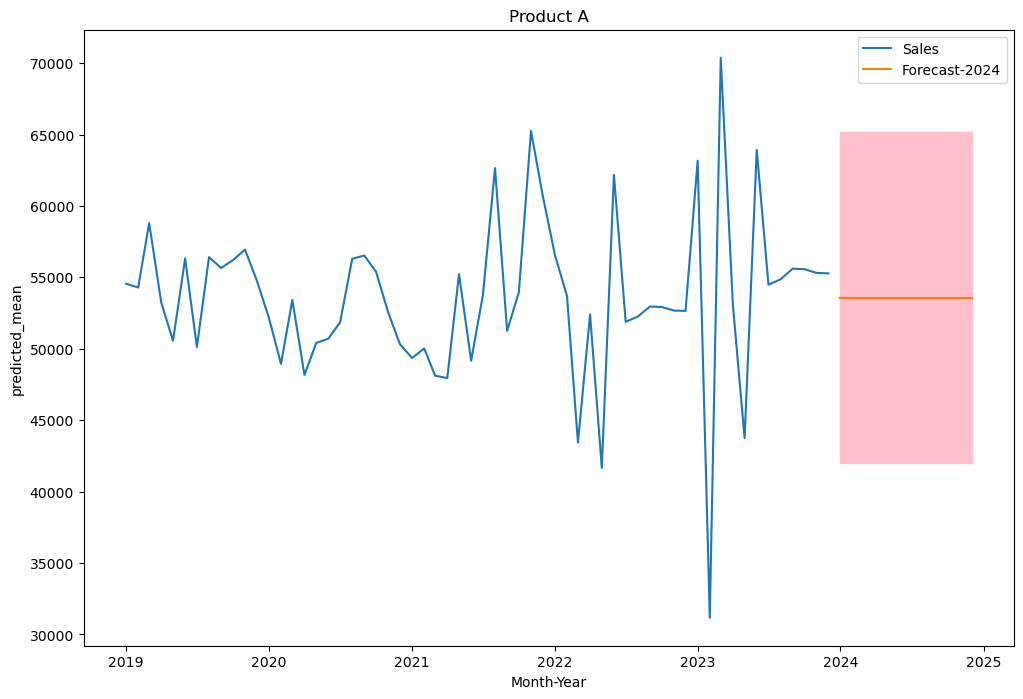

In [188]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_a[['Sales']])
sns.lineplot(mean_forecast,label='Forecast-2024')
#plt.plot(mean_forecast,color='red',label='Forecast-2024')
plt.fill_between(dates,confidence_intervals['lower Sales'],confidence_intervals['upper Sales'],color='pink')
plt.title('Product A')
plt.show()

# SARIMA

In [189]:
import statsmodels.api as sm

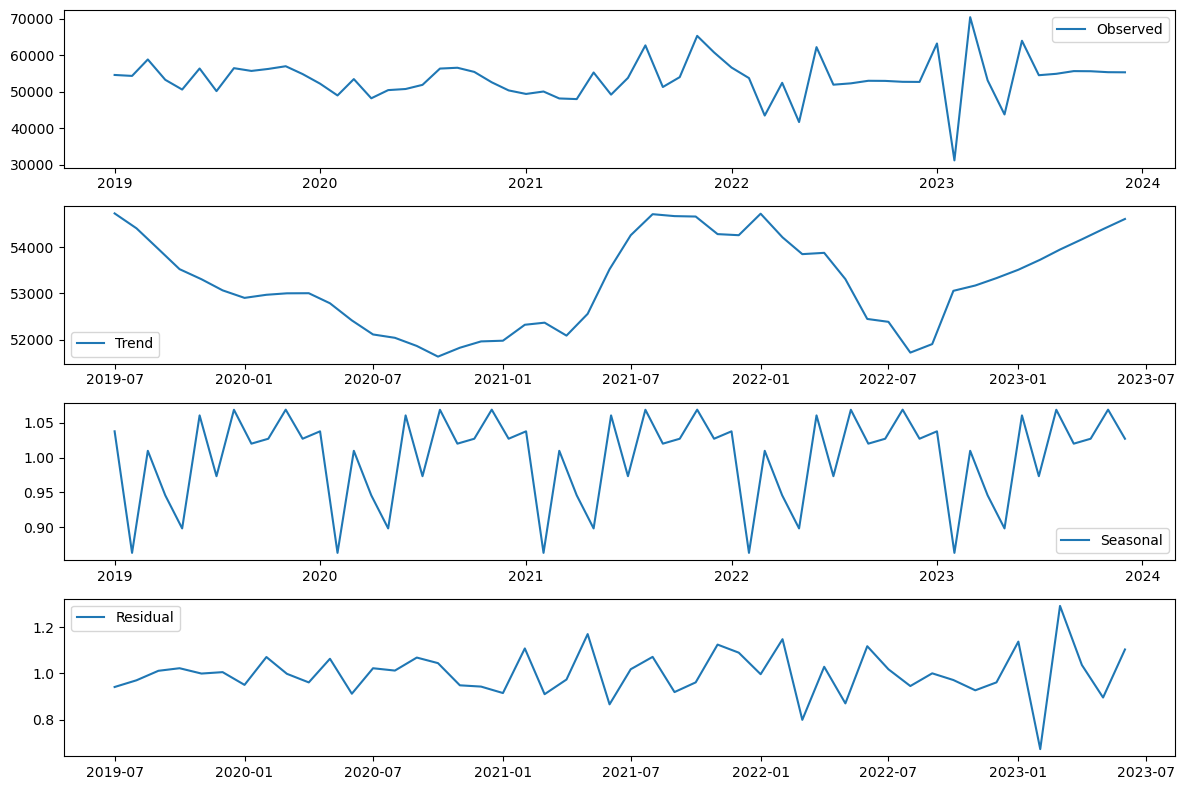

In [190]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(sales_a['Sales'], model='multiplicative', period=12)

# Plot the decomposition
#fig = decomposition.plot(figsize=(12,8))
#plt.show()
# Create a new figure with the specified size
plt.figure(figsize=(12, 8))

# Plot each component separately
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

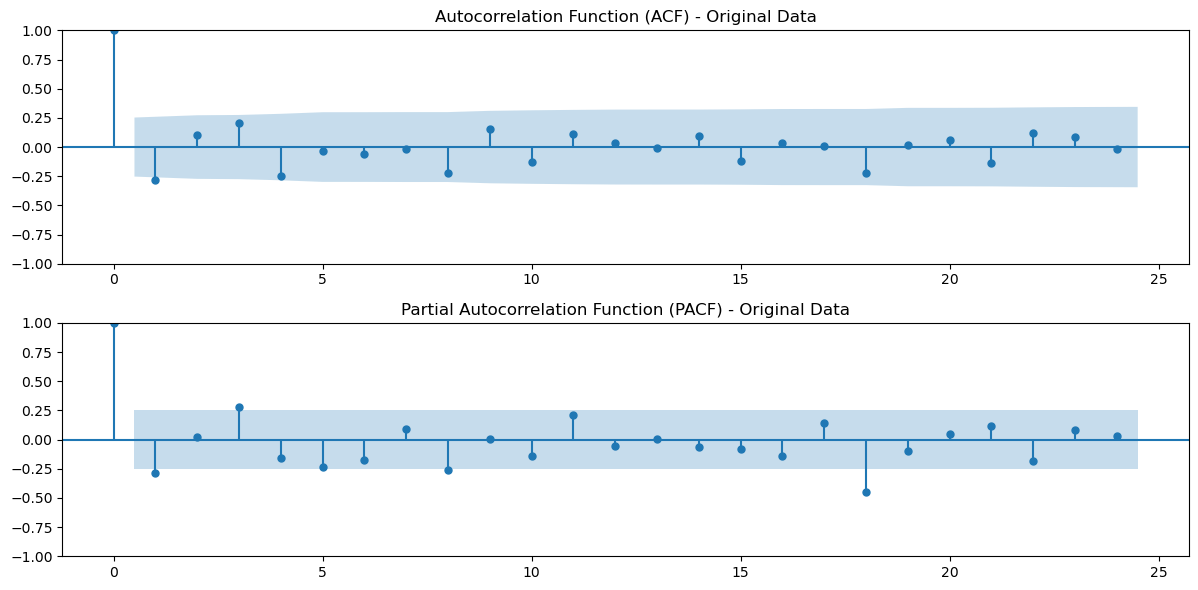

In [191]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_a['Sales'], lags=24, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Original Data')

plt.subplot(212)
plot_pacf(sales_a['Sales'], lags=24, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Original Data')

plt.tight_layout()
plt.show()

In [194]:
order_SARIMAX=[]
# Loop over P order
for P in range(6):
    # Loop over Q order
    for Q in range(2):
        # Fit model
        model_s = sm.tsa.statespace.SARIMAX(train['Sales'], order=(0, 0, 0), seasonal_order=(P, 0, Q, 12))
        model_test_s = model_s.fit() 
        pred = model_test_s.predict(start=48, end=59, dynamic=True)
#        mae = mean_absolute_error(test, pred)
#        mse = mean_squared_error(test, pred)
        # Add order and scores to list        
        order_SARIMAX.append((P, Q, model_test_s.aic, model_test_s.bic))

# Make DataFrame of model order and scores
order_SARIMAX_df = pd.DataFrame(order_SARIMAX, columns=['P', 'Q', 'aic', 'bic'])


In [195]:
# Sort by AIC
print(order_SARIMAX_df.sort_values('aic'))

    P  Q          aic          bic
6   3  0  1024.205858  1031.690662
3   1  1  1024.574485  1030.188088
5   2  1  1024.584403  1032.069207
4   2  0  1024.928863  1030.542466
8   4  0  1025.881724  1035.237729
7   3  1  1026.260891  1035.616896
9   4  1  1027.881718  1039.108924
10  5  0  1027.881721  1039.108927
2   1  0  1029.857261  1033.599663
11  5  1  1029.881719  1042.980126
1   0  1  1148.470760  1152.213162
0   0  0  1183.336894  1185.208095


In [196]:
sarima=sm.tsa.statespace.SARIMAX(train['Sales'],order=(0,0,0),seasonal_order=(3,0,0,12))
sarima_model=sarima.fit()

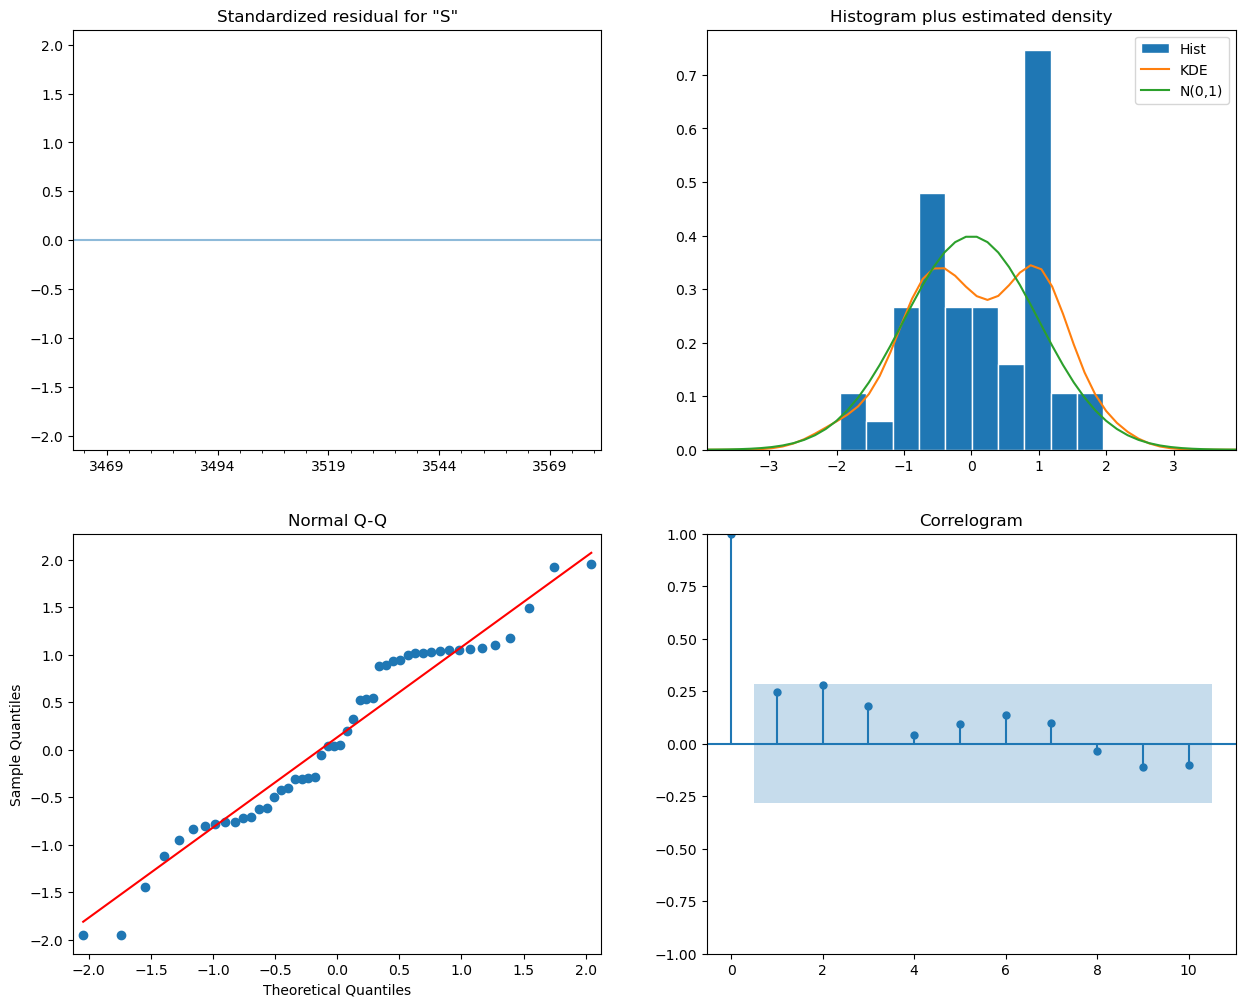

In [197]:
sarima_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [198]:
forecast_test_sarima=sarima_model.predict(start=48,end=59,dynamic=True)

In [199]:
sales_a['Forecast_SARIMA']=[None]*len(train)+ list(forecast_test_sarima)
#sales_b[['Sales','Forecast_SARIMA']].plot(figsize=(12,8))

Text(0.5, 1.0, 'Product A')

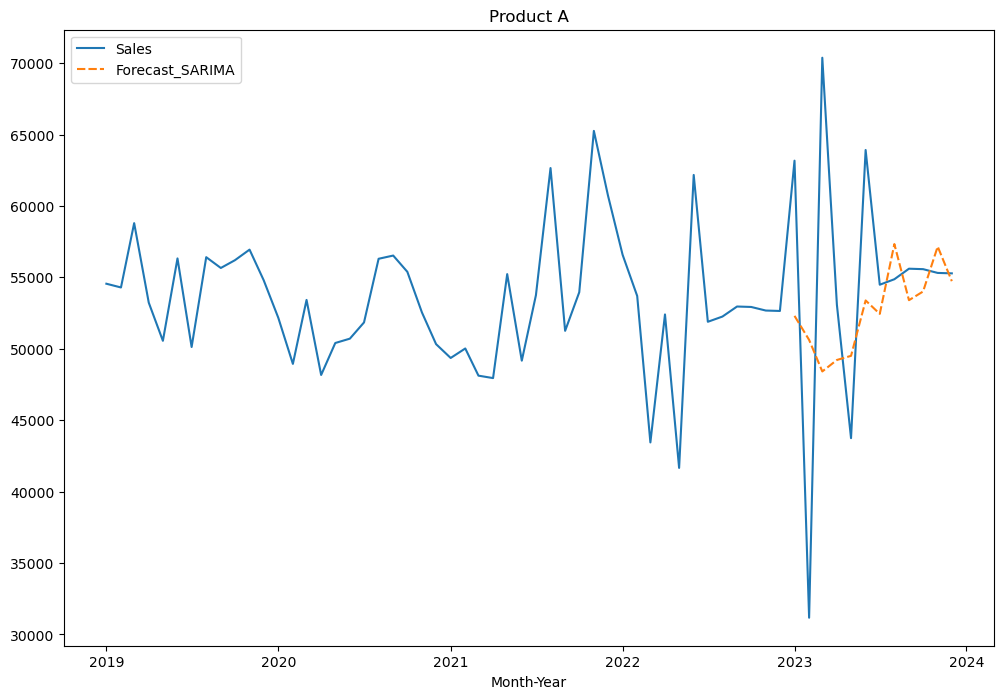

In [200]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_a[['Sales','Forecast_SARIMA']])
plt.title('Product A')

In [201]:
mae_sarima= mean_absolute_error(test,forecast_test_sarima)
mape_sarima= mean_absolute_percentage_error(test,forecast_test_sarima)
mse_sarima=mean_squared_error(test, forecast_test_sarima)
rmse_sarima= np.sqrt(mean_squared_error(test,forecast_test_sarima))

print(f'MAE - SARIMA: {round(mae_sarima,3)}')
print(f'MAPE - SARIMA: {round(mape_sarima,3)}')
print(f'MSE - SARIMA: {round(mse_sarima,3)}')
print(f'RMSE - SARIMA: {round(rmse_sarima,3)}')

MAE - SARIMA: 6926.771
MAPE - SARIMA: 0.139
MSE - SARIMA: 96630760.587
RMSE - SARIMA: 9830.095


# FORECASTING

In [202]:
sarima_forecast=sm.tsa.statespace.SARIMAX(sales_a['Sales'],order=(0,0,0),seasonal_order=(3,0,0,12))
sarima_model_f=sarima_forecast.fit()

In [204]:
forecast_sarima=sarima_model_f.predict(start=60,end=71,dynamic=True)

In [205]:
forecast_sarima

2024-01-01    57675.789142
2024-02-01    40864.569496
2024-03-01    58244.833293
2024-04-01    51242.851342
2024-05-01    46155.907885
2024-06-01    59191.647162
2024-07-01    53424.362065
2024-08-01    56106.872595
2024-09-01    53549.969395
2024-10-01    54258.496929
2024-11-01    57125.932179
2024-12-01    55879.264023
Freq: MS, Name: predicted_mean, dtype: float64

Text(0.5, 1.0, 'Product A')

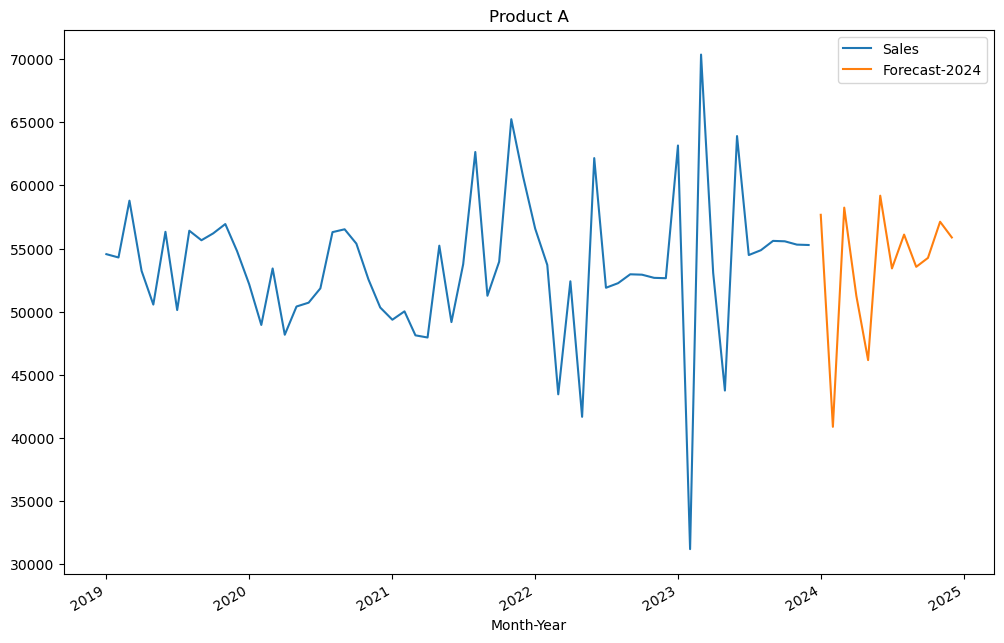

In [206]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_a[['Sales']])
forecast_sarima.plot(legend=True, label='Forecast-2024')
plt.title('Product A')

In [207]:
sarima_forecast_model=sarima_model_f.get_forecast(steps=6)

mean_forecast_sarima= sarima_forecast_model.predicted_mean
dates = mean_forecast_sarima.index

confidence_intervals_sarima= sarima_forecast_model.conf_int()

In [208]:
print(mean_forecast_sarima,confidence_intervals_sarima)

2024-01-01    57675.789142
2024-02-01    40864.569496
2024-03-01    58244.833293
2024-04-01    51242.851342
2024-05-01    46155.907885
2024-06-01    59191.647162
Freq: MS, Name: predicted_mean, dtype: float64              lower Sales   upper Sales
2024-01-01  42618.395419  72733.182866
2024-02-01  25807.175773  55921.963219
2024-03-01  43187.439570  73302.227017
2024-04-01  36185.457619  66300.245065
2024-05-01  31098.514162  61213.301608
2024-06-01  44134.253439  74249.040885


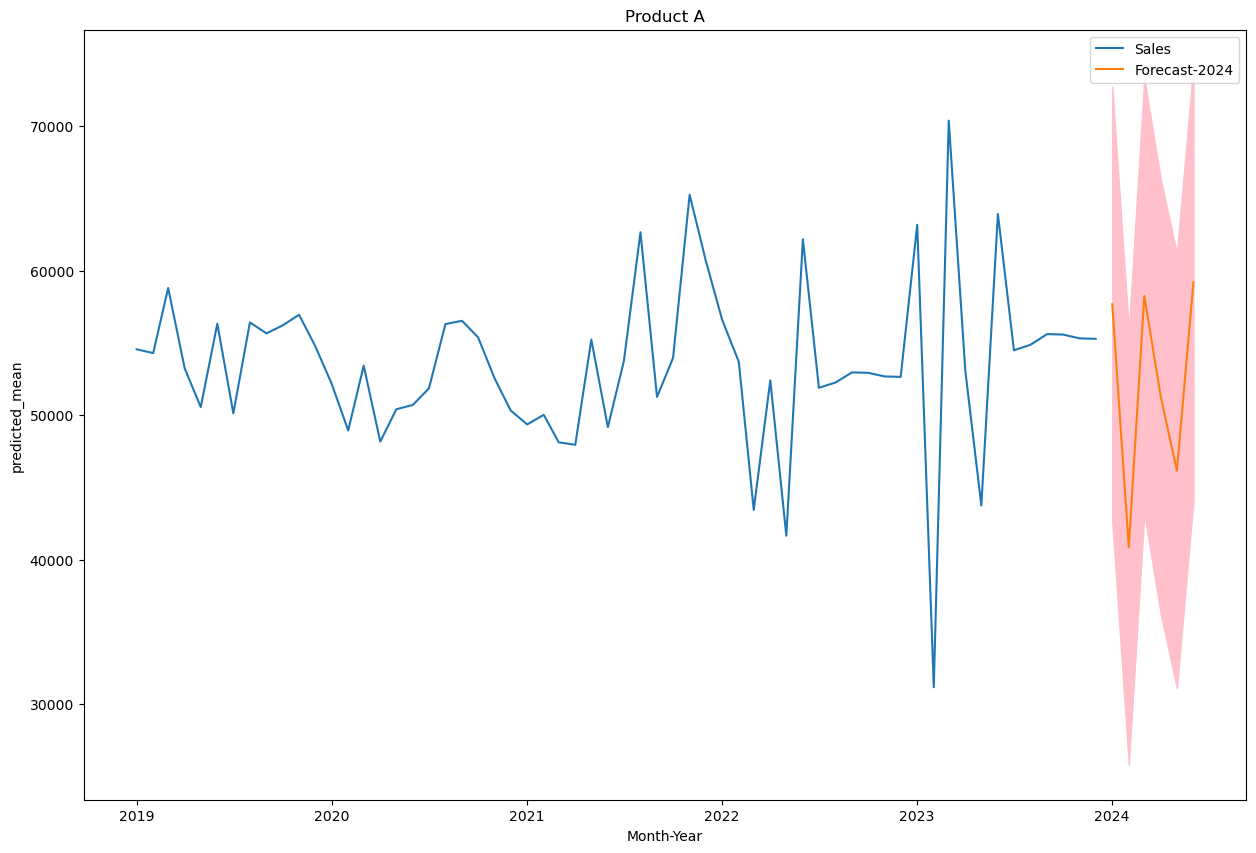

In [209]:
plt.figure(figsize=(15, 10))
sns.lineplot(sales_a[['Sales']])
sns.lineplot(mean_forecast_sarima,label='Forecast-2024')
#plt.plot(mean_forecast,color='red',label='Forecast-2024')
plt.fill_between(dates,confidence_intervals_sarima['lower Sales'],confidence_intervals_sarima['upper Sales'],color='pink')
plt.title('Product A')
plt.show()

# AUTO-ARIMA

In [210]:
import pmdarima as pm

In [211]:
auto_arima= pm.auto_arima(train, start_p=0, start_q=0, max_p=5,max_q=2,
                          start_P=0, start_Q=0, max_P=5 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=944.915, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=946.894, Time=0.04 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=948.774, Time=0.08 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=946.915, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=948.894, Time=0.22 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=950.774, Time=0.24 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=948.903, Time=0.42 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=950.777, Time=0.80 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=952.775, Time=0.25 sec
 ARIMA(0,0,0)(3,0,0)[12] intercept   : AIC=950.858, Time=2.11 sec
 ARIMA(0,0,0)(3,0,1)[12] intercept   : AIC=954.368, Time=2.17 sec
 ARIMA(0,0,0)(3,0,2)[12] intercept   : AIC=954.758, Time=1.38 sec
 ARIMA(0,0,0)(4,0,0)[12] intercept   : AIC=952.770, Time=5.92 sec
 ARIMA(0,0,0)(4,0,1)[12] intercept   : AIC=954.762, Time=3.60 sec
 ARIMA(0,0,0)(5,0,0)[12] intercept   : AIC=954.763, Time=12.81 sec
 ARIMA(0,

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [212]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:                        SARIMAX   Log Likelihood                -470.458
Date:                Tue, 14 May 2024   AIC                            944.915
Time:                        18:03:25   BIC                            948.658
Sample:                    01-01-2019   HQIC                           946.329
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.328e+04    634.460     83.976      0.000     5.2e+04    5.45e+04
sigma2      1.909e+07   3.18e+06      5.998      0.000    1.28e+07    2.53e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.70   Jarque-Bera (JB):                 2.44
Prob(Q):                              0.40   Prob(JB):                         0.30
Heteroskedasticity (H):               3.64   Skew:                             0.19
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

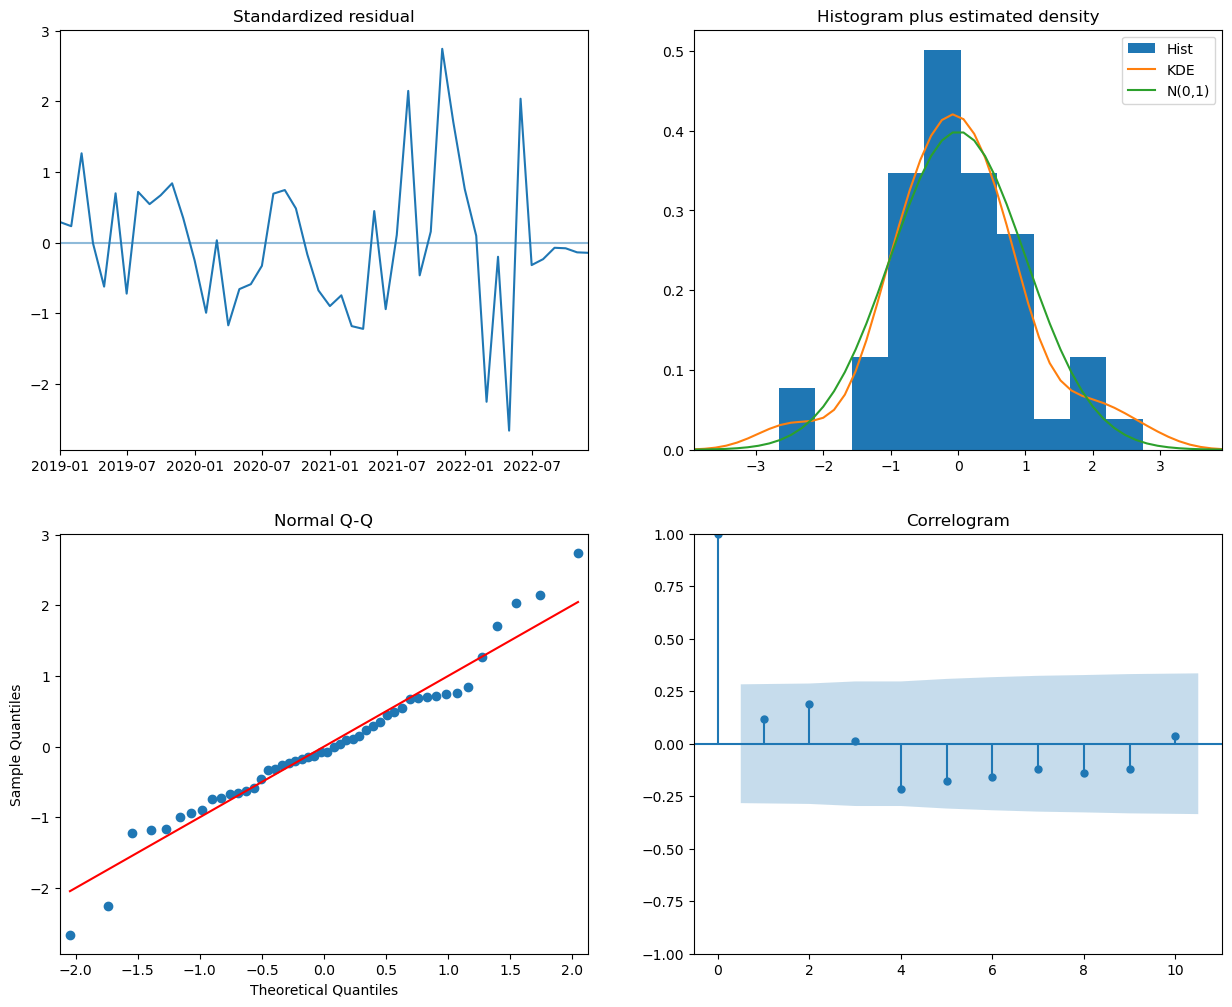

In [213]:
auto_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [214]:
forecast_test_auto= auto_arima.predict(n_periods=len(test))
sales_a['Forecast_AUTO ARIMA']=[None]*len(train)+ list(forecast_test_auto)
#sales_b[['Sales','Forecast_AUTO ARIMA']].plot()

Text(0.5, 1.0, 'Product A')

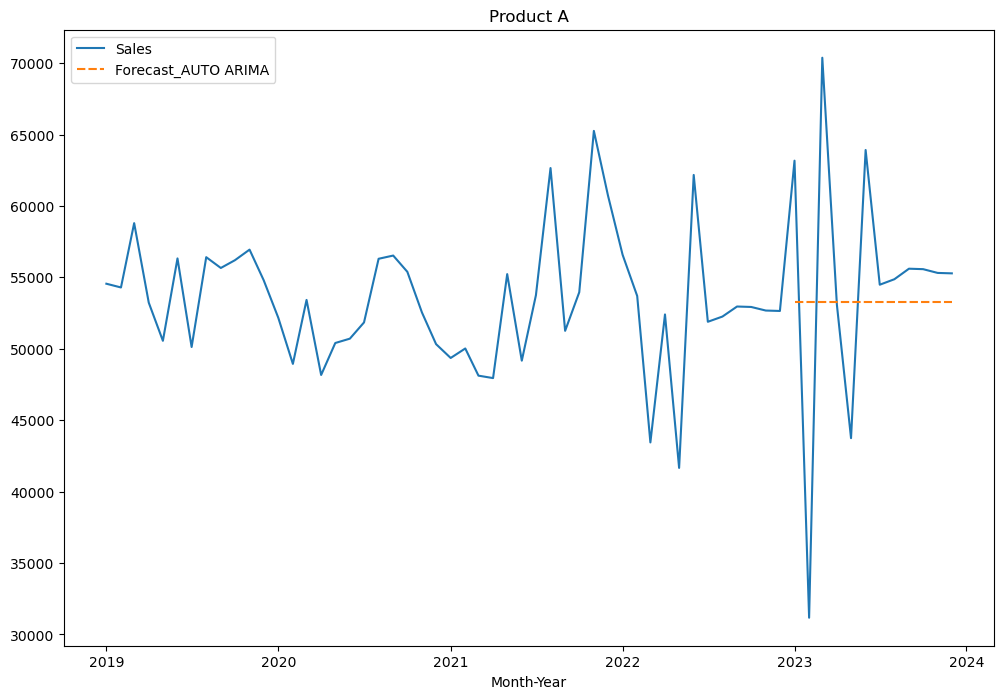

In [215]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_a[['Sales','Forecast_AUTO ARIMA']])
plt.title('Product A')

In [216]:
mae_auto_arima= mean_absolute_error(test,forecast_test_auto)
mape_auto_arima= mean_absolute_percentage_error(test,forecast_test_auto)
mse_auto_arima=mean_squared_error(test,forecast_test_auto)
rmse_auto_arima= np.sqrt(mean_squared_error(test,forecast_test_auto))

print(f'MAE - AUTO ARIMA: {mae_auto_arima}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima}')

MAE - AUTO ARIMA: 6744.593749999988
MAPE - AUTO ARIMA: 0.1420423384192015
MSE - AUTO ARIMA: 92184635.2539062
RMSE - AUTO ARIMA: 9601.283000407091


# FORECASTING

In [78]:
auto_arima_forecast= pm.auto_arima(sales_a['Sales'], start_p=0, start_q=0, max_p=5,max_q=2,
                          start_P=0, start_Q=0, max_P=5 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima_forecast

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1214.118, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1215.970, Time=0.05 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=1217.933, Time=0.10 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1216.117, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1217.969, Time=0.18 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=1219.930, Time=0.24 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=1217.962, Time=0.15 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=1219.937, Time=0.42 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=1221.920, Time=0.73 sec
 ARIMA(0,0,0)(3,0,0)[12] intercept   : AIC=1219.820, Time=1.87 sec
 ARIMA(0,0,0)(3,0,1)[12] intercept   : AIC=1221.681, Time=2.95 sec
 ARIMA(0,0,0)(3,0,2)[12] intercept   : AIC=1223.003, Time=3.20 sec
 ARIMA(0,0,0)(4,0,0)[12] intercept   : AIC=1221.597, Time=4.71 sec
 ARIMA(0,0,0)(4,0,1)[12] intercept   : AIC=1222.811, Time=9.11 sec
 ARIMA(0,0,0)(5,0,0)[12] intercept   : AIC=1223.090, Time=7.76

ARIMA(order=(2, 0, 2), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [79]:
forecast_autoarima= auto_arima_forecast.predict(n_periods=6)

In [80]:
forecast_autoarima

2024-01-01    52406.703855
2024-02-01    57822.911501
2024-03-01    54261.321324
2024-04-01    51281.095789
2024-05-01    53195.426221
2024-06-01    54834.884431
Freq: MS, dtype: float64

Text(0.5, 1.0, 'Product A')

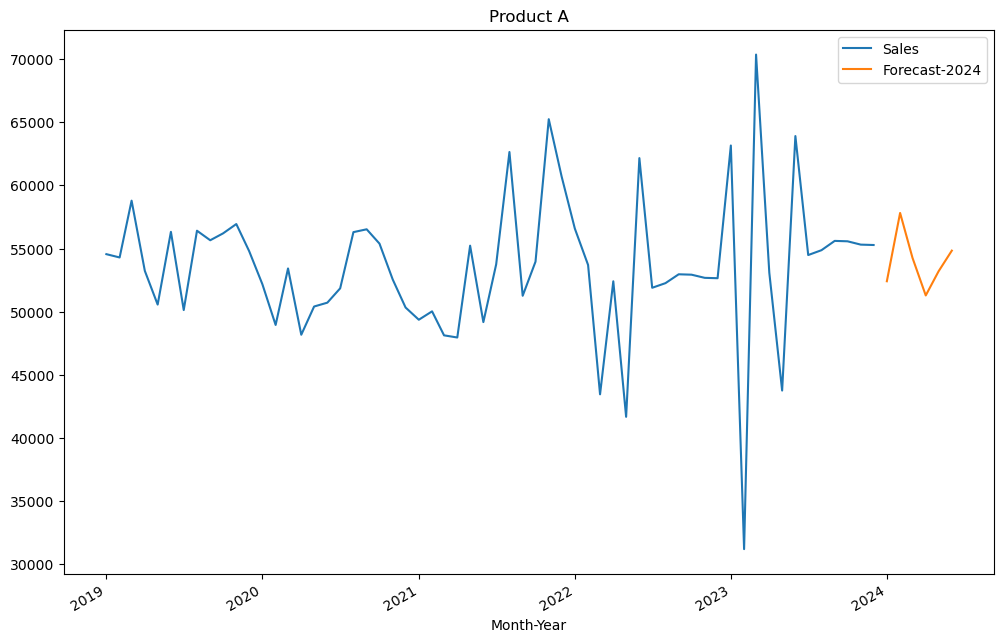

In [81]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_a[['Sales']])
forecast_autoarima.plot(legend=True, label='Forecast-2024')
plt.title('Product A')

In [66]:
sales_b.tail(12)

,Sales,Forecast_ARIMA,Forecast_SARIMA,Forecast_AUTO ARIMA
Month-Year,,,,
2023-01-01,514369,NaN,NaN,NaN
2023-02-01,1767039,NaN,NaN,NaN
2023-03-01,981026,NaN,NaN,NaN
2023-04-01,1589911,NaN,NaN,NaN
2023-05-01,692905,NaN,NaN,NaN
2023-06-01,1651940,NaN,NaN,NaN
2023-07-01,929333,9.905082e+05,8.382960e+05,8.382960e+05
2023-08-01,1690948,1.422065e+06,1.851662e+06,1.851662e+06
2023-09-01,1033615,9.699533e+05,9.033150e+05,9.033150e+05


In [67]:
sales_b.mean()

Sales                  1.166948e+06
Forecast_ARIMA         1.210029e+06
Forecast_SARIMA        1.369218e+06
Forecast_AUTO ARIMA    1.369218e+06
dtype: float64

In [68]:
data = {
    'model': ['ARIMA', 'AUTO ARIMA', 'SEASONAL ARIMA'],
    'MAE': [mae_arima, mae_auto_arima, mae_sarima],  
    'MAPE': [mape_arima, mape_auto_arima, mape_sarima],  
    'MSE': [mse_arima, mse_auto_arima, mse_sarima],  
    'RMSE': [rmse_arima, rmse_auto_arima, rmse_sarima]  
}

model_results = pd.DataFrame(data)
model_results.set_index('model', inplace=True)
model_results

,MAE,MAPE,MSE,RMSE
model,,,,
ARIMA,166597.132727,0.107702,4.435206e+10,210599.284180
AUTO ARIMA,129784.560914,0.104798,1.985243e+10,140898.653558
SEASONAL ARIMA,129784.560914,0.104798,1.985243e+10,140898.653558


# TESTING

In [18]:
auto_arima_1= pm.auto_arima(train, start_p=0, start_q=0, max_p=5,max_q=3,
                          start_P=0, start_Q=0, max_P=2 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima_1

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1559.555, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1557.064, Time=0.04 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=1556.276, Time=0.12 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1559.598, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1557.081, Time=0.11 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=1558.274, Time=0.24 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1557.757, Time=0.11 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1557.940, Time=0.43 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=1559.793, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1520.667, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1515.886, Time=0.07 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1517.437, Time=0.16 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1520.840, Time=0.07 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1516.194, Time=0.12 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=0.53 sec


ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 0, 1, 12),
      suppress_warnings=True)

In [19]:
auto_arima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   54
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -747.556
Date:                            Wed, 08 May 2024   AIC                           1505.112
Time:                                    18:22:52   BIC                           1514.963
Sample:                                01-01-2019   HQIC                          1508.900
                                     - 06-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.996e+04    1.3e+04      1.538      0.124   -5479.007    4.54e+04
ar.L1         -0.4477      0.171     -2.614      0.009      -0.783      -0.112
ma.L1         -0.8422      0.121     -6.986      0.000      -1.079      -0.606
ma.S.L12       0.4670      0.199      2.349      0.019       0.077       0.857
sigma2      1.092e+11      0.002   5.39e+13      0.000    1.09e+11    1.09e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                 1.25
Prob(Q):                              0.63   Prob(JB):                         0.54
Heteroskedasticity (H):               1.21   Skew:                            -0.37
Prob(H) (two-sided):                  0.69   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.18e+29. Standard errors may be unstable.
"""

In [20]:
forecast_test_auto_1= auto_arima_1.predict(n_periods=len(test))
sales_b['Forecast_AUTO ARIMA_1']=[None]*len(train)+ list(forecast_test_auto_1)

Text(0.5, 1.0, 'Product B')

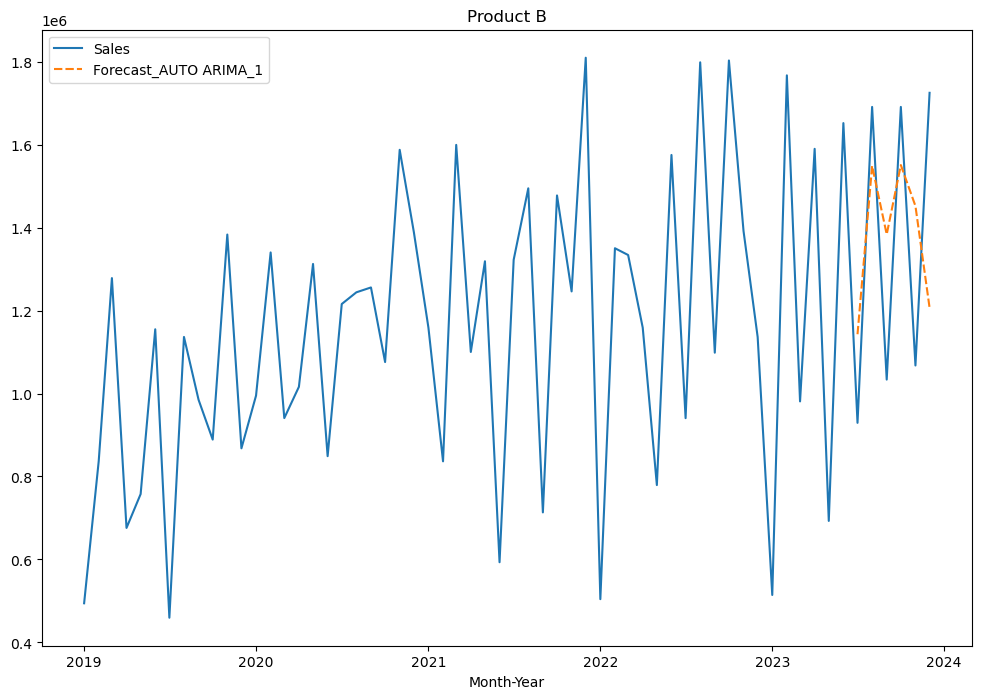

In [21]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_b[['Sales','Forecast_AUTO ARIMA_1']])
plt.title('Product B')

In [22]:
mae_auto_arima_1= mean_absolute_error(test,forecast_test_auto_1)
mape_auto_arima_1= mean_absolute_percentage_error(test,forecast_test_auto_1)
mse_auto_arima_1=mean_squared_error(test,forecast_test_auto_1)
rmse_auto_arima_1= np.sqrt(mean_squared_error(test,forecast_test_auto_1))

print(f'MAE - AUTO ARIMA: {mae_auto_arima_1}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima_1}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima_1}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima_1}')

MAE - AUTO ARIMA: 291387.67920569534
MAPE - AUTO ARIMA: 0.23262955579809455
MSE - AUTO ARIMA: 104031582112.00275
RMSE - AUTO ARIMA: 322539.2722010806
